In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from helper_funcs import conv2d_output_shape, MaxPool2d_output_shape

In [2]:
trainset = datasets.MNIST(root='./data', train=True, download=False, transform = transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=False, transform = transforms.ToTensor())

In [3]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
images, labels = next(iter(trainloader))

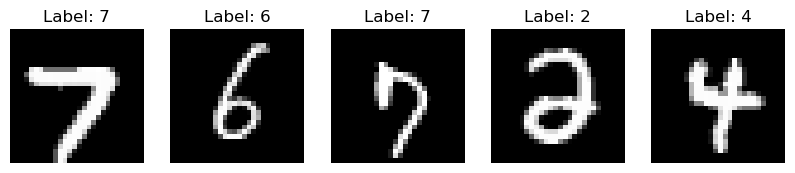

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for idx in range(5):
    img_tensor = images[idx]
    label = labels[idx].item()

    img_np = img_tensor.squeeze().numpy()

    axes[idx].imshow(img_np, cmap='gray')
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis("off")
plt.show()

In [6]:
from models.full_models.mnist_base_classifier import MnistBaseClassifier

In [7]:
model = MnistBaseClassifier()
checkpoint = torch.load("saved_models/mnist_cnn_encoder/best_weights.pth", weights_only=True)
model.encoder.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
for param in model.encoder.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    print(f"{name} - Trainable: {param.requires_grad}")

encoder.conv1.0.weight - Trainable: False
encoder.conv1.0.bias - Trainable: False
encoder.conv2.0.weight - Trainable: False
encoder.conv2.0.bias - Trainable: False
encoder.fc1.0.weight - Trainable: False
encoder.fc1.0.bias - Trainable: False
model.fc1.weight - Trainable: True
model.fc1.bias - Trainable: True


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.model.parameters(), lr=1e-3)

In [10]:
num_epochs = 5
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    model.train()
    current_loss = 0.0
    for img_tensor, label in trainloader:
        output = model(img_tensor)
        
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
    avg_train_loss = current_loss / len(trainloader)
    train_loss.append(avg_train_loss)
   
    model.eval()
    current_loss = 0.0
    with torch.no_grad():
        for img_tensor, label in testloader:
            output = model(img_tensor)
            loss = criterion(output, label)
            current_loss += loss.item()
    avg_test_loss = current_loss / len(testloader)
    test_loss.append(avg_test_loss)
    if (epoch % 5) == 0:
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.3f}; Test Loss {avg_test_loss:.3f}")


Epoch 1: Train Loss 0.759; Test Loss 0.276


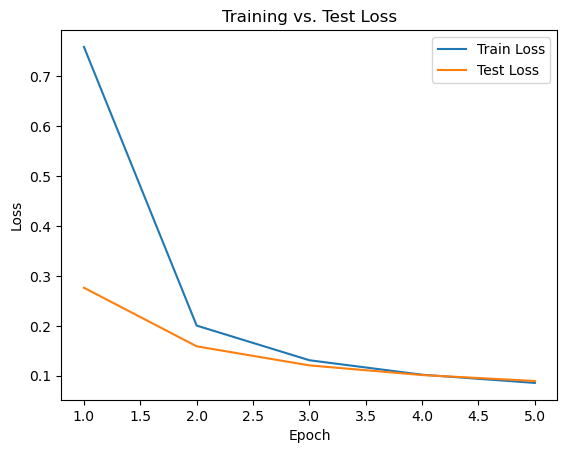

In [11]:
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Test Loss")
plt.show()

In [17]:
def calc_train_test_accuracy(model, trainloader, testloader):
    model.eval()
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    with torch.no_grad():
        for img_tensor, label in trainloader:
            output = model(img_tensor)
            _, predicted = torch.max(output, dim=1)
            train_total += label.size(0)
            train_correct += (predicted == label).sum().item()
        for img_tensor, label in testloader:
            output = model(img_tensor)
            _, predicted = torch.max(output, dim=1)
            test_total += label.size(0)
            test_correct += (predicted == label).sum().item()
    train_accuracy = round(train_correct / train_total * 100, 2)
    test_accuracy = round(test_correct / test_total * 100, 2)
    return train_accuracy, test_accuracy

In [18]:
calc_train_test_accuracy(model, trainloader, testloader)

(99.22, 98.49)

In [19]:
torch.save(model.state_dict(), "saved_models/mnist_base_classifier/best_weights.pth")